In [1]:
import matplotlib.pyplot as plt
import matplotlib
from collections import deque
import scipy.stats as st
import requests, re
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
from scipy.stats import norm

# Analysis of IMDb Movie Metadata

We believe almost everyone must have asked a question: What should I watch tonight? <br>
A lot of people try to explore movies from IMDb, potentialy the IMDb's list of "top rated" movies.<br>
However, there are some questions we may need to answer in order to make sense of the IMDb scores: Are the movie scores really informative? What do they mean? What results in the difference in the scores?

In this project, we intend to explore the variables that may be related to the movie scores to give people insights into understanding the IMDb movie scores.

We will explore this topic in the following order:
- [Data Collection and Preprocessing](#Data-Collection-and-Preprocessing)
- [Score Calculation](#Score-Calculation)
- [Film Genres as a Feature](#Film-Genres-as-a-Feature)
- [Release Years as a Feature](#Release-Years-as-a-Feature)
- [Linear Regression](#Linear-Regression)
- [Movie Descriptions Text Analysis](#Movie-Descriptions-Text-Analysis)
- [Conclusions](#Conclusions)
- [Future Investigations](#Future-Investigations)
- [Sources Consulted](#Sources-Consulted)

## Data Collection and Preprocessing

### Web Scraping

We scraped the IMDb website for movie metadata and started from the advanced search result page so we would only get results with valid number of ratings. We collected data of US films from __1950 to 2010__. 
The raw metadata looks like this: 
![alt webpage](https://i.imgur.com/LnntOMw.png)



In order to obtain the data, we used 2 libraries. First we get the webpages in HTML using __requests__. Secondly we used __beautiful soup__ to parse the HTML and retrive the features. For the features, we decided to encode genre as 1s and 0s using __one-hot encoding__ which will facilitate our further investigation.


In [2]:
GENRES = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 
'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
FORMATTED = ["Genre_"+genre for genre in GENRES]

the function that parses a single HTML page

In [3]:
def parse_page(html, df):
    def parse_votes(resultSet):
        try:
            nvs = resultSet[0].find_all("span", {"name" :"nv"})
            if (len(nvs) == 1):
                return (int(nvs[0].text.replace(",", "")), np.nan)
            return (int(nvs[0].text.replace(",", "")), nvs[1].text)
        except: 
            return (0,0)
    
    soup = BeautifulSoup(html, 'html.parser')
    # make a list of movies
    listerlist = soup.find_all('div', class_ = "lister-item mode-advanced")
    
    # get all the titles
    imgList = [movieItem.find('img') for movieItem in listerlist]
    nameList = [imgItem["alt"] for imgItem in imgList]
    
    # get all the ratings
    ratingsRaw = [movieItem.find("strong") for movieItem in listerlist]
    ratings = [float(rawRating.text) for rawRating in ratingsRaw]

    # get the number of votes. Due to the weird HTML structure, the gross and vote are listed together so it needs to be parsed
    voteNumRaw = [movieItem.find_all("p", class_="sort-num_votes-visible") for movieItem in listerlist]
    votes = [parse_votes(raw) for raw in voteNumRaw]

    # get the year of release
    yearsRaw = [movieItem.find("span", class_ = "lister-item-year text-muted unbold") for movieItem in listerlist]
    years = [int(re.findall("\d{4}", rawYear.text)[0]) for rawYear in yearsRaw]

    # get the list of genres of a film
    genresRaw = [movieItem.find("span", class_ = "genre") for movieItem in listerlist]
    genres = [(list(map(lambda x: x.strip(), rawGenre.text.split(","))) if (rawGenre !=None) else []) for rawGenre in genresRaw]
    
    # get the summaries. Sometimes there is some exception due to the ill-formatted HTML
    try:
        summaryRaw = [movieItem.find_all("p", class_="text-muted") for movieItem in listerlist]
        summaries = [raw[1].text.strip() for raw in summaryRaw]
    except:
        summaries = [""] * len(nameList)

    # insert a film as a column to the overall data frame
    for i in range(len(nameList)):  
        info = dict()
        info["Name"] = nameList[i]
        info["Rating"] = ratings[i]
        info["Year"] =  years[i]
        info["Votes"] = votes[i][0]
        info["Gross"] = votes[i][1]
        info["Summary"] = summaries[i]

        for GENRE in GENRES:
            info["Genre_" + GENRE] = (int(GENRE in genres[i]))
        df = df.append(info, ignore_index=True)
    
    # retrieve the link to the next 250 movies
    nextRaw = soup.select("a.lister-page-next.next-page")
    nextURL = nextRaw[0]["href"] if (len(nextRaw) > 0) else None
    if (nextURL != None):
        nextURL = "http://www.imdb.com/search/title"+nextURL
    return(df, nextURL)

below is an example of a processed webpage.

In [4]:
d = pd.DataFrame(columns=(['Name', "Rating", "Year", "Votes", "Gross", "Summary"]+FORMATTED))
html = requests.get("https://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc").text
(df, link) = (parse_page(html, d))
print(link)
df.head(1)

http://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc&page=2&ref_=adv_nxt


,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,Paranormal Activity: The Marked Ones,5.0,2014,35349,$32.46M,When a young man becomes the target of a malev...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Then we followed the "next page" one the search results to crawl all the data.
During this process, we observed that there is a weird behavior of IMDb. It only gives us 10,000 films from a query in advanced search. So we separated our call into 3 to get the data.

In [5]:
# the function that get the html text all related to one link.
def parseAllAfter1950(url, fileName):
    df = pd.DataFrame(columns=(['Name', "Rating", "Year", "Votes", "Gross", "Summary"] + FORMATTED))
    while(url):
        html = requests.get(url).text
        try:
            (df, url) = parse_page(html, df)
        except:
            print(url)
        sleep(0.2)
    # save to a pickle for future use
    df.to_pickle(fileName)
    
# link = "http://www.imdb.com/search/title?title_type=feature&release_date=1950-01-01,&num_votes=1,&countries=us&sort=release_date,asc"
# link2 = "http://www.imdb.com/search/title?title_type=feature&release_date=1985-10-04,&num_votes=1,&countries=us&sort=release_date,asc"
# link3 = "http://www.imdb.com/search/title?title_type=feature&release_date=2001-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc"

After scraping, we concatenated the dataframes together to get a complete data set. We got about __30,000__ observations.

In [6]:
df1 = pd.read_pickle("mov-1.pkl")
df2 = pd.read_pickle("mov-2.pkl")
df3 = pd.read_pickle("mov-3.pkl")
movie_df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
movie_df.shape

(29947, 32)

### Cleaning

We only need data to last decade, so we first got rid of the useless data.

In [7]:
movie_df = movie_df[movie_df['Year'] <= 2010]

Then we observed that some genres only have very few movie instances. This is problematic for our future processing so we removed those genres.

In [8]:
#remove genres
generes = movie_df.columns[6:]
genre_count = movie_df.iloc[:,6:].sum()
genres_to_remove= movie_df.iloc[:,6:].columns[(genre_count < 200)]
try:
    movie_df = movie_df.drop(genres_to_remove, axis = 1)
except:
    pass

The last step we did to the data frame is to process the gross column (which was text in the format "$1.5M" into numbers that can be used.

In [9]:
def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan    
movie_df["Gross"] = movie_df["Gross"].apply(parse_gross)

By now, we have got a movie_df data frame that contains all the information we may use to analyze.

In [10]:
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Score Calculation

### Definition of movie score
It is biased to merely investigate into either movie rating or movie number of votes to find popular and successful movies. Therefore, we introduce the formula from [IMDb](https://help.imdb.com/article/imdb/featured-content/why-doesn-t-a-title-with-the-average-user-vote-of-9-4-appear-in-your-top-250-movies-or-tv-list/GTU67Q5QQ8W53RJT?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=e31d89dd-322d-4646-8962-327b42fe94b1&pf_rd_r=T4PZFWW3YAJD79YH14HS&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=top&ref_=cons_chttp_learnmore#) to get the combined values. 

The formula gives a true Bayesian estimate: weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C Where:
 - R = rating for the movie = (Rating)
 - v = number of votes for the movie = (votes)
 - m = the threshold of the number of vote for a movie to be considered as popular(we pick m as the first quantile for number of votes)
 - C = the mean ratings of all movies

The following true_bayesian_estimate_1 returns the scores for all rows in the dataframe, and true_bayesian_estimate calculate the average scores for every genre movie in the dataframe. 

In [11]:
def get_values(df):
    v = []
    R = []
    # loop through genres
    for genre in df.columns[6:-1]:
        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C

def true_bayesian_estimate(df):
    '''
        df: movie data frame
        return: the scores for each genre movie average score in the dataframe(the movie)
    '''
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C

def true_bayesian_estimate_1(df):
    '''
        df: movie data frame
        return: the scores for each row in the dataframe(the movie)
    '''
    R = df["Rating"]
    v = df["Votes"]
    m = v.quantile([.25, .5, .75])[0.25] #the first quantile for number of votes
    C = (R).mean()
    return (v/(v+m))*R + (m/(v+m))*C

### Add Scores to the Data Frame
We call our movie scores as "Score" in the dataframe

In [12]:
ps = true_bayesian_estimate_1(movie_df)
ps = np.nan_to_num(ps)
movie_df = movie_df.assign(Score = pd.Series(ps).values.astype("float"))

### Split Data into Decades
We partitioned the data into decades since we decide to investigate the movie market changes for each 10 years from 1950 to 2010. dfs is a list of partitioned dataframes. 

In [13]:
dfs = []
years = list(range(1950, 2000, 10))
for start in range(1950, 2010, 10):
    dfs.append(movie_df[np.logical_and(movie_df['Year'] >= start, movie_df['Year'] < (start + 10))])

### Score Distribution
We found the scores centered around 5 and 6. We also found that the normal curve fits the true distribution well.

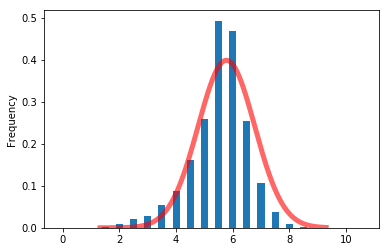

In [14]:
r = movie_df['Score']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed = True)
x = np.linspace(r.min(), r.max(), r.shape[0])
rv = norm(loc = np.mean(r), scale = np.std(r))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


## Film Genres as a Feature
### How Scores Vary Across Genres
We first explored the relationship between genres and score, using bar graph.
The top four categories are ['Biography', 'History', 'Film-Noir', 'Animation']


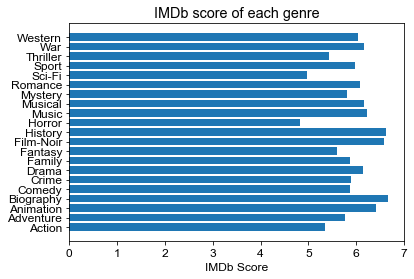

['Biography', 'History', 'Film-Noir', 'Animation']

In [15]:
y = true_bayesian_estimate(movie_df)
font = {'family' : 'Arial',
        'size'   : 12}
matplotlib.rc('font', **font)
labels = list(movie_df.columns[6:-1])
labels = [x.replace('Genre_','') for x in labels]
y = np.nan_to_num(y)
plt.barh(labels, y)
plt.xlabel('IMDb Score')
plt.title("IMDb score of each genre")
plt.show()
plt.savefig('scorevsgenre.png')
indx = (-y).argsort()[:4]
top_genres = [labels[i] for i in indx ]
top_genres

### Hypothesis Testing

We want to make sure that there is actually a difference between these top genres and other genres.  
 $H_0: \mu_1 = \mu_2$ There is no difference in scores between each one of the top genres and the other genres  
 $H_a: \mu_1 > \mu_2$ The top genres have higher scores
 
Note: $\mu_1$ is the score under each genre in the top genres, and $\mu_2$ is the scores of other genres

We got our p-values for each group less than 0.05. With these statistically significant small p-values, we conclude that those top genres have higher scores.

In [16]:
for i in range(len(top_genres)):
    a = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 1]["Score"]
    b = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 0]["Score"]
    t2, p2 = st.ttest_ind(a,b)
    print(top_genres[i] + " p-value: " + str(p2))


Biography p-value: 6.138597461894906e-98
History p-value: 1.3152522452700892e-53
Film-Noir p-value: 7.615937248872615e-46
Animation p-value: 1.106686845157151e-32


We also investigated which genres have lowest average scores:

In [18]:
indx1 = (y).argsort()[:4]
worst_genres = [labels[i] for i in indx1 ]
worst_genres

['Horror', 'Sci-Fi', 'Action', 'Thriller']

### Genre Score over Years Visualization
Since we have those assumptions validated above, it is possible to get a clearer idea of top genres over the decades using a heatmap. We plotted a heatmap to view the average ratings of different genres in all decades.
The horizontal axis is the movie genre, the vertical axis is the decades and lighter cells indicate higher average scores.

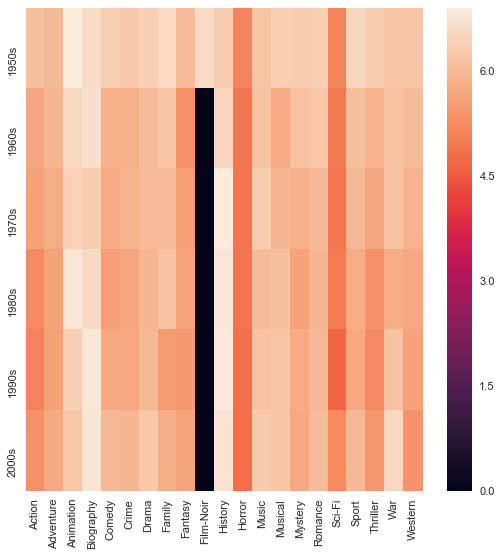

In [19]:
import seaborn as sns; sns.set()
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')

all_years = pd.DataFrame(columns = [ col.split("_")[1] for col in movie_df.columns[6:-1]])
for i in range(6):
    df = dfs[i]
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    all_years.loc[i] = y
all_years.index = [str(start)+"s" for start in range(1950, 2010, 10)]
ax = sns.heatmap(all_years)

From the plot we can observe that the "Film-Noir" column looks very abnormal. Therefore we further explored the reason why a lot of values for "Film-Noir" is missing. We searched the wikipedia entry of [Film-Noir](https://en.wikipedia.org/wiki/Film_noir)
>Film noir (/fɪlm nwɑːr/; French pronunciation: ​[film nwaʁ]) is a cinematic term used primarily to describe stylish Hollywood crime dramas, particularly those which emphasize cynical attitudes and sexual motivations. Hollywood's classical film noir period is generally regarded as extending from the early 1940s to the late 1950s. 

Voila! We see that this genre of film only last to late 1950s, and that explains why the values are missing.
To better understand the trends of the other genres, we plotted a new heatmap with that genre excluded.

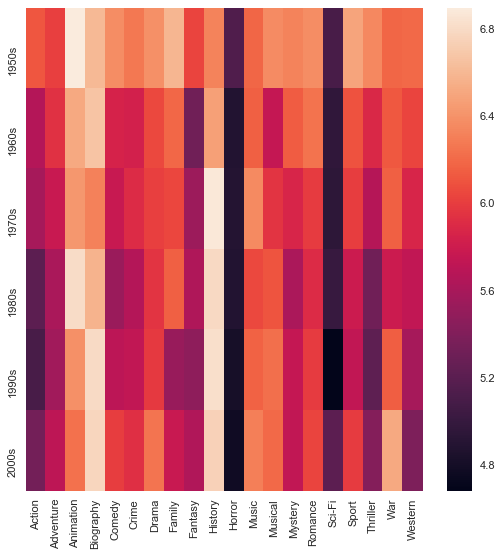

In [20]:
fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
all_years_without_fn = all_years.drop(["Film-Noir"], axis = 1)
ax = sns.heatmap(all_years_without_fn)

From the plot above we can see that there are certain trends. Action, Western movies are becoming more and more poorly-rated and the Biography and History categories are becoming more and more highly-rated. It also shows us that horror films and Sci-Fi films have low scores almost in all decades.

## Release Years as a Feature
Another variable might relate to the scores is the release years.
Below are the boxplots over six decades shows that there are some variations in scores over years. 

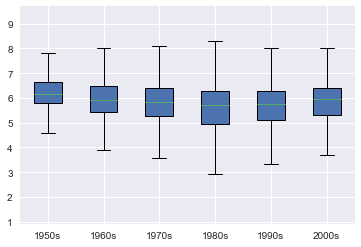

In [21]:
data = []
all_years = [str(start)+"s"  for start in range(1950, 2010, 10)]
for i in range(len(dfs)):
    data.append(list(dfs[i]['Score']))
plt.boxplot(data, patch_artist=True)
plt.xticks(range(1,len(all_years)+1), all_years)

plt.show()

### Time Series Analysis

The plots above also shows that the year is probably related to the scores. So we made a further investigation on the effect of years on the scores. We performed a __Time Series__ Analysis. 
To find the trend of the gross over years, we applied the __sliding average__ on this time series data to smooth out short-term flucatuations and find the longer-term trend. (the slidingaverage code is from our homework submission)

In [22]:
# the class used to compute the sliding averages
class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1

### Score and Years
We first plotted the scores against the year released.

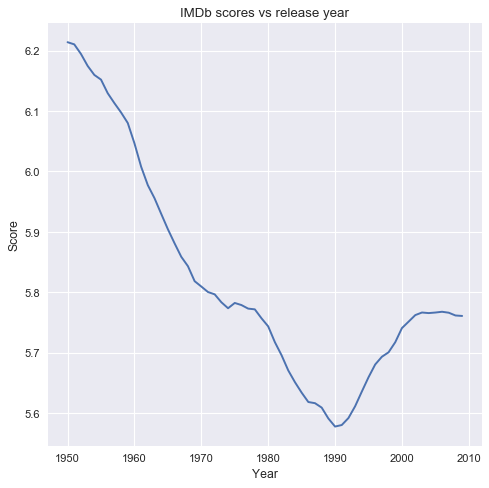

In [23]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')

pop_y = movie_df.groupby(['Year'])['Score'].mean()
pop_y_slide_average = compute_sliding_averages(pd.Series(pop_y),5)
plt.plot(range(1950, 2010), pop_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("IMDb scores vs release year")

plt.show()

From the plot above, we observed that there is a significant drop around the 1980s and 1990s. Is the trend also evident in other metrics?

### Gross and Years
Below is a plot of Gross against years.

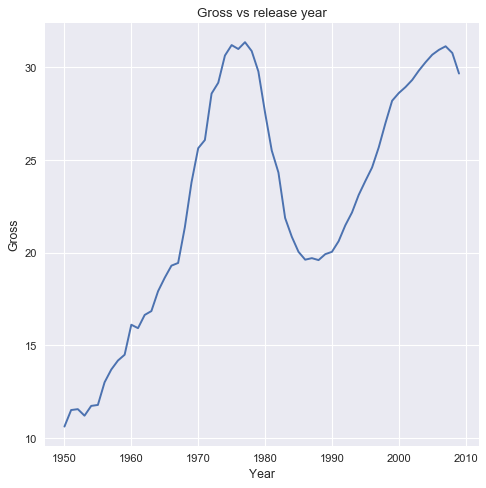

In [24]:
subdf = movie_df.dropna()
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Gross")
plt.title("Gross vs release year")
plt.show()

Not surprising, there is also a significant drop in the average gross as in the scores trend. This makes us wonder: What can be the reason behind this drop?   
We presumed that it may be possible that is a boom in the movie market around 1980s and 1990s, and the quality of movie dropped of the lowered standard. 

### Movie Count and Years
We tried to plot the trend of the movie count of years.

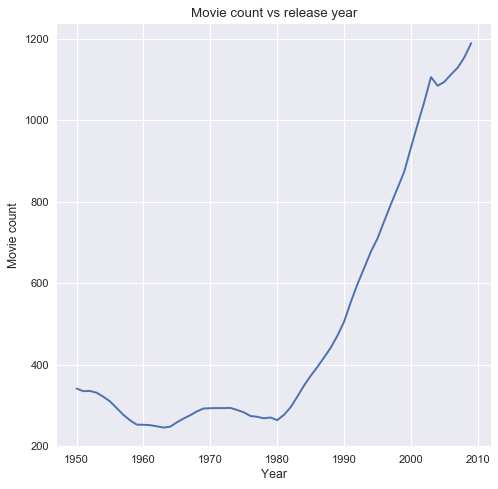

In [25]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')

count_y = movie_df.groupby(['Year'])['Name'].count()
count_y_slide_average = compute_sliding_averages(pd.Series(count_y),5)
plt.plot(range(1950, 2010), count_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Movie count")
plt.title("Movie count vs release year")

plt.show()

From the plot above, it is clear that the count of movie produced a year started to drastically increase at around 1980s. This trend supports our presumption above. There may also be some other reasons, we can further investigate on that in the future.

## Linear Regression
### Relationship Between Gross and Score
Before we run linear regression on the Score over Gross, we first made a scatter plot and check if there is any relationship. The graph below indicated there might be a positive relationship. 

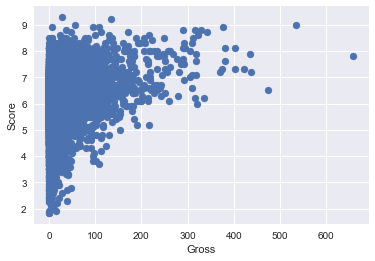

In [26]:
plt.scatter(movie_df["Gross"].values.reshape(-1, 1), movie_df["Score"])
plt.xlabel("Gross")
plt.ylabel("Score")
plt.show()

We will ran the linear regression model using sklearn with the model below:  
$Score = \beta_1*Gross + \beta_0 + \epsilon$  
P-value for $\beta_1$ is significantly small so we conclude that there is a positive linear relationship between score and gross. However, the R-squared is small, which means that the variability in the score cannot only be explained by the variation of the gross.

In [27]:
from regressors import stats
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = movie_df.dropna()
X = np.asarray(subdf["Gross"]).reshape(-1,1)
y = np.asarray(subdf["Score"])
lm.fit(X, y)
stats.summary(lm, X, y)

Residuals:
Min      1Q  Median      3Q     Max
-3.0947 -0.6668 -0.0789  0.5754  4.2275


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept  6.046672    0.013440  449.8876      0.0
x1          0.005595    0.000228   24.4941      0.0
---
R-squared:  0.06141,    Adjusted R-squared:  0.06128
F-statistic: 460.50 on 1 features


### Linear Regression on All Three Features Combined
Therefore, we want to include more variables. Based on our analysis above, genre, gross, and year all relate to the score.  
Then, we run the linear regression on all these features:   
$\mathrm{Score} = \beta_0 + \beta_{1}  \mathrm{Year} 
    + \beta_{2}  \mathrm{Action}   
    + \beta_{3}  \mathrm{Adventure} +   \mathrm{...} 
    + \beta_{21}  \mathrm{War} 
    + \beta_{22}  \mathrm{Gross}  + \epsilon$

In [28]:
lm = LinearRegression(fit_intercept=True, normalize=False)  
generes = subdf.columns[5:]
X1 = np.asarray(subdf.iloc[:,[2]+list(range(6,subdf.shape[1] - 2))+ [4]], dtype='float')
y1 = np.asarray(subdf["Score"], dtype='float')
lm.fit(X1, y1)
stats.summary(lm, X1, y1)

Residuals:
Min      1Q  Median      3Q     Max
-2.599 -0.5956 -0.0641  0.5022  4.2368


Coefficients:
             Estimate  Std. Error    t value   p value
_intercept  31.275867    1.867628    16.7463  0.000000
x1          -0.012717    0.000006 -2203.4946  0.000000
x2          -0.390765    0.031595   -12.3680  0.000000
x3          -0.041779    0.035402    -1.1801  0.237987
x4           0.401758    0.064938     6.1868  0.000000
x5           0.419144    0.054839     7.6432  0.000000
x6          -0.204573    0.025059    -8.1636  0.000000
x7           0.081497    0.029022     2.8081  0.004997
x8           0.492132    0.025125    19.5876  0.000000
x9          -0.346969    0.043941    -7.8962  0.000000
x10         -0.072575    0.044113    -1.6452  0.099972
x11          0.653561    0.295087     2.2148  0.026805
x12          0.201022    0.073338     2.7410  0.006140
x13         -0.347187    0.041517    -8.3626  0.000000
x14         -0.103506    0.057903    -1.7876  0.073886
x15          0.044

The cell below pulls out all the features that are significant (p-value < 0.05). We observe that with same year and gross, people rate Action, Family, Horror lower, but Animation, Biography, Drama, Film-Noir higher. 

In [29]:
coefs = lm.coef_
pvals = stats.coef_pval(lm, X1, y1)
variable_names = [subdf.columns[2]]+ list(subdf.columns[6:subdf.shape[1] - 2]) + ["Gross"]
zipped = list(zip(variable_names, coefs, pvals[1:]))
important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped ]
variable_names = ["Year"]+list(map(lambda x: x.split("_")[1], variable_names[1:-1]))+["Gross"]
significant_coefs = pd.DataFrame({'variable': variable_names,
     'beta': coefs,
     'p-value': pvals[1:]
    })
# important_factors
significant_coefs[significant_coefs["p-value"]<=0.05]

,beta,p-value,variable
0,-0.012717,0.000000e+00,Year
1,-0.390765,0.000000e+00,Action
3,0.401758,6.485434e-10,Animation
4,0.419144,2.398082e-14,Biography
5,-0.204573,2.220446e-16,Comedy
6,0.081497,4.996646e-03,Crime
7,0.492132,0.000000e+00,Drama
8,-0.346969,3.330669e-15,Family
10,0.653561,2.680499e-02,Film-Noir
11,0.201022,6.139865e-03,History


## Movie Descriptions Text Analysis

When people are comparing films to pick the ones they want to see, people take the descriptions of films into account besides the quantitative factors we investigated. So we did an analysis on the movie descriptions to give people an idea on what distinguishes the descriptions of good and bad movies.    
We chose to train a __naive bayes classifier__ from the descriptions and reported the most informative word features.  
First, we assigned the tags to the films. Movies with less than 4 points will be labeled as poorly scored movies and movies with a score higher than 7 will be highly scored. Labeling like this gives us about the same number of documents in the poorly rated  pool and the highly rated pool.

In [30]:
# this code is adapted from https://pythonprogramming.net/words-as-features-nltk-tutorial/?completed=/text-classification-nltk-tutorial/
import nltk, re
from collections import Counter
from nltk.tokenize import word_tokenize
import random
random.seed(10)
# labeling function
def assign_label(x):
    if x < 4:
        return "poorly"
    if x < 7:
        return np.nan
    return "highly"

# get the label
ind = movie_df['Score'].apply(assign_label)
df_text = movie_df
df_text['ind'] = ind.values
df_text = df_text.drop("Gross", axis = 1)
df_text = df_text.dropna()

res = []

# helper function that tokenize the text into a word list
def to_list(w):
    w = re.sub(r'[^\w\s]','',w)
    return word_tokenize(w.lower())

documents = list(zip(df_text.Summary.apply(to_list), df_text.ind))
random.shuffle(documents)

# get the word features
all_words = list(filter(lambda x: len(x) >1, word_tokenize(re.sub(r'[^\w\s]'," "," ".join(df_text["Summary"])).lower())))
all_words = nltk.FreqDist(all_words)
word_features = [ w for (w,c) in list(all_words.most_common(1000)) if w != "ii"]

# convert a document into a feature set
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# create the feature sets
featuresets = [(find_features(rev), category) for (rev, category) in documents]
training_set = featuresets[:3000]

# train the classifier 
classifier = nltk.NaiveBayesClassifier.train(training_set)

Before looking at the most informative features, we can check the accuracy of the classifier.

In [31]:
testing_set = featuresets[3000:]
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Classifier accuracy percent: 72.59887005649718


Although the accuracy is not particularly strong, given the sample size it is pretty good.
Lets see what features it gives us.

In [32]:
classifier.show_most_informative_features(20)

Most Informative Features
                    hell = True           poorly : highly =     13.8 : 1.0
                 ancient = True           poorly : highly =     13.8 : 1.0
                 zombies = True           poorly : highly =     12.0 : 1.0
                 accused = True           highly : poorly =     10.8 : 1.0
                 english = True           highly : poorly =     10.3 : 1.0
                 crashes = True           poorly : highly =     10.2 : 1.0
                   woods = True           poorly : highly =      9.8 : 1.0
                  crazed = True           poorly : highly =      9.3 : 1.0
                   witch = True           poorly : highly =      9.3 : 1.0
              determined = True           highly : poorly =      8.8 : 1.0
               struggles = True           highly : poorly =      8.6 : 1.0
                   widow = True           highly : poorly =      7.8 : 1.0
                gangster = True           highly : poorly =      7.8 : 1.0

From the most informative features we can see that films related to "british", "accused", "englisj", "determined", "widow" are very likely to be a good movie and the ones related to supernatural forces and violence are likely to be poorly rated. The word "hell" is 13.8 times more likely to occur in a movie with poor scores. This is interesting and aligns with our discovery of the score differences towards genres.

## Conclusions

From this analysis, we can see that there is a relationship between the movie scores and the film genre, release year, and gross. Although the score of movie from IMDb is a good measure of movie quality, they vary significantly across genres.   
For example, the scores of more serious categories like "Biography" and "History" have relatively higher scores in general, but they may be films that majority of us won't enjoy.  
Be aware of those factors (year, genres, ...) and don’t blindly believe the scores!   
A 4 star horror movie may already be the best horror film of that decade!

## Future Investigations

- Explore more features that may explain the variability in the scores. (Eg. Actors and Directors can influence the scores)
- Investigate more on some abnormal observations. 
- Run some other machine learning models on the data. (Eg. SVM)

## Sources Consulted
Libraries:
	Sklearn, regressors, nltk, pandas, numpy, requests, beautiful soup  
Sources:  
https://pythonprogramming.net/words-as-features-nltk-tutorial/?completed=/text-classification-nltk-tutorial/  
https://www.quora.com/How-does-IMDbs-rating-system-work  
https://stats.stackexchange.com/questions/189658/what-are-good-resources-on-bayesian-rating	  

